# Lab 4 - Chain of Thoughts ; Self-Consistency ; Tree-of-Thoughts

This lab focus on implementing the parallel sampling strategies we saw during Lecture 4:
- Chain-of-Thoughts ([*Chain-of-Thought Prompting Elicits Reasoning in Large Language Models*](https://arxiv.org/pdf/2201.11903))
- Self-Consistency ([*Self-Consistency Improves Chain of Thought Reasoning in Language Models*](https://arxiv.org/pdf/2203.11171))
- Tree-of-Thoughts  ([*Tree of Thoughts: Deliberate Problem Solving with Large Language Models*](https://arxiv.org/pdf/2305.10601))


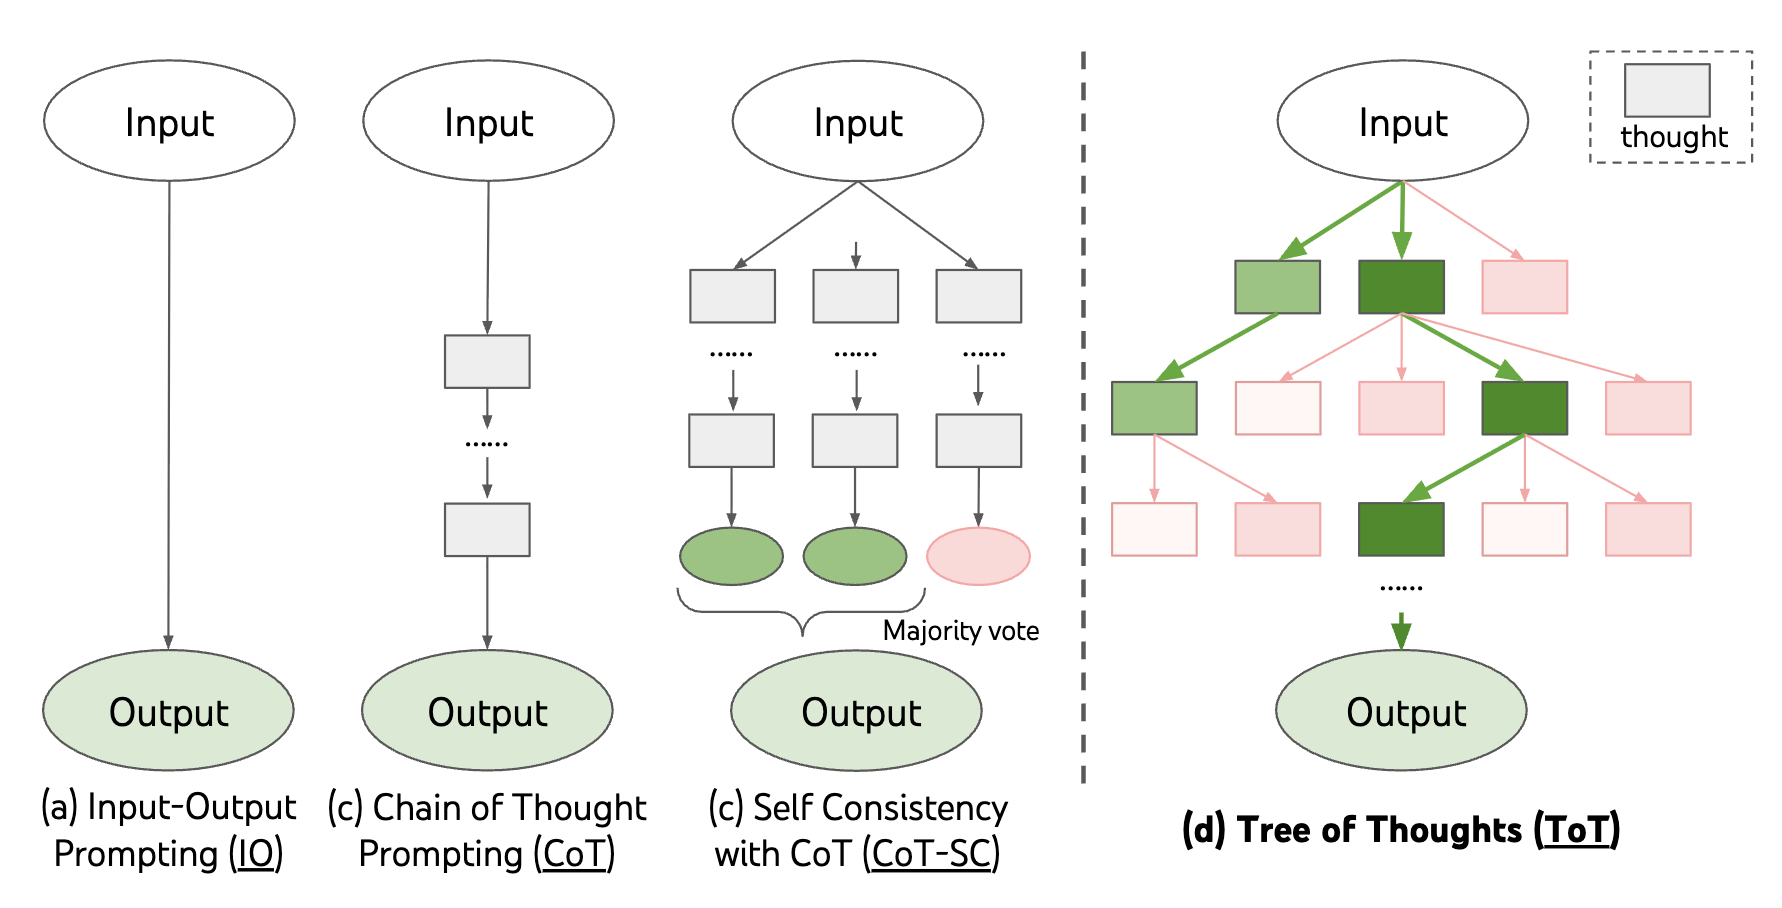

### Data

We will focus on implementing each strategy, and compare their performance on the **GSM8k** dataset that features Grade-School Maths questions along with their answer (and importantly, the reasoning traces to arrive at that answer).

### Model

We will use [**Gemma3-1b**](https://huggingface.co/google/gemma-3-1b-it) as the base LLM for Part 1 experiments. The goal here is to use a relatively small model that can run on Google Collab GPUs, and who's able to deliver answers relatively fast.

### Inference Infrastructre

The inference infrastructure we'll use is [**Ollama**](https://docs.ollama.com/). Ollama runs a background local server where the LLM will be hosted. The LLM can then be accessed via API calls to the local server. It's quite convenient as it runs well with Google Collab.

# Setup

Make sure you use a **GPU Runtime** so that you have access to Collab GPUs.

Follow these steps:

- Click on "Runtime"
- "Change runetime type"
- Select "T4 GPU"
- Restart Runtime

Verify you have a 15360MiB Tesla T4 GPU with the following command

In [ ]:
!nvidia-smi

In [300]:
# Runtime variables
MODEL_NAME = 'gemma3:1b' # In this lab we'll use gemma3-1b as the base LLM

In [ ]:
# Install dependancies (ollama and others)
!apt install lshw pciutils zstd -y
!curl https://ollama.ai/install.sh | sh
!pip install ollama toml

In [ ]:

# Setup ollama: we open an Ollama server. To make the server work in backgeround, we use "nohup"
# We also specify the number of parallel requests possible. This will increase throughput later on
!nohup ollama serve &

In [ ]:
# Downloading the base model (here Gemma-3 but full list is available at https://ollama.com/search)
!ollama pull $MODEL_NAME

# Dataset Import: GSM8K

GSM8K ([*Training Verifiers to Solve Math Word Problems*](https://arxiv.org/pdf/2110.14168)) is a dataset featuring Grade-School maths word problems.
Each data point is $(question, solution, answer)$ tuple where the solutions are annotated with *reasoning steps and calcualtions* to arrive at the *final answer*. Below are some facts on GSM8K:

- These problems take between 2 and 8 steps to solve.

- Solutions primarily involve performing a sequence of elementary calculations using basic arithmetic operations (+ − ×÷) to reach the final answer.

- A bright middle school student should be able to solve every problem

- Solutions are provided in natural language, as opposed to pure math expressions.


We will pull the dataset from Huggingface

In [1]:
from datasets import load_dataset

dataset = load_dataset('openai/gsm8k', 'main')

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GSM8K comes two splits: `train` and `test`
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})


In [3]:
import random

train_dataset = dataset['train']
test_dataset = dataset['test']

num_train = len(train_dataset)
num_test = len(test_dataset)

# picking a random example from train test
sample_idx = random.randint(0,num_train-1)
sample = train_dataset[sample_idx]

print(f'Question:\n\n{sample["question"]}\n\n' + '-'*50 + f'\n\nAnswer\n\n{sample["answer"]}')

Question:

A spiral notebook costs $15, and a personal planner costs $10. How much would it cost in total to buy 4 spiral notebooks and 8 personal planners at a 20% discount?

--------------------------------------------------

Answer

If a spiral notebook cost $15, a 20% discount would reduce the price by 20/100 *15 = $<<15*0.2=3>>3
At a 20% discount, the buying price of a spiral notebook book is $15-$3= $<<15-3=12>>12
At the same discount, a personal planner cost would reduce by 20/100 * $10 = $<<20/100*10=2>>2
The new buying price of a personal planner will be $10-$2 =$<<10-2=8>>8
To buy four spiral notebooks at a 20% discount, you'll pay 4*$12 = $<<4*12=48>>48
At the same time discount, you'll buy eight personal planners at a cost pf 8*$8 = <<8*8=64>>64
In total, to buy eight personal planners and four spiral notebooks, you'd have to pay $64+$48 = $112
#### 112


You can see above that the **Answers** have a quite specific format:

- Calculations performed by human annotators are available in **"<<..>>"** substrings
- The final answer is provided after the string pattern "\n#### "

**These annotations are not useful in our case.**

**Exercise: complete the following functions:**
- `extract_answer` extracts the final answer. There might some format errors in a few samples in the train dataset. Make sure your function handle these cases and return the `INVALID_ANSWER`.
- `extract_reasoning` Extract the reasoning part and remove the annotations

#### Exercise

In [4]:
import re
INVALID_ANSWER = '[invalid]'

def extract_answer(text) :
  match = re.search("INSERT REGEX", text)

  # handle cases where the regex match returns nothing
  if match :
    return "..."
  else :
    return '...'

def extract_reasoning(text) :
  # replacing the reasoning part
  reasoning = re.sub('INSERT REGEX', '' ,text)
  # replacing the answer part
  return re.sub("INSERT REGEX", '' , reasoning)

In [5]:
question = sample['question']
reasoning = extract_reasoning(sample['answer'])
answer = extract_answer(sample['answer'])


In [6]:
print(f'Question:\n{question}\n\nReasoning:\n{reasoning}\n\nAnswer:\n{answer}')

Question:
A spiral notebook costs $15, and a personal planner costs $10. How much would it cost in total to buy 4 spiral notebooks and 8 personal planners at a 20% discount?

Reasoning:
If a spiral notebook cost $15, a 20% discount would reduce the price by 20/100 *15 = $3
At a 20% discount, the buying price of a spiral notebook book is $15-$3= $12
At the same discount, a personal planner cost would reduce by 20/100 * $10 = $2
The new buying price of a personal planner will be $10-$2 =$8
To buy four spiral notebooks at a 20% discount, you'll pay 4*$12 = $48
At the same time discount, you'll buy eight personal planners at a cost pf 8*$8 = 64
In total, to buy eight personal planners and four spiral notebooks, you'd have to pay $64+$48 = $112

Answer:
112


# Part 1: CoT and Self-Consistency

## Chain-Of-Thought Prompting

In contrast to standard prompting, where models are asked to directly produce the final answer, 'Chain of Thought Prompting' encourages LLMs to generate intermediate reasoning steps before providing the final answer to a problem. The advantage of this technique lies in its ability to break down complex problems into manageable, intermediate steps. By doing this, the model-generated 'chain of thought' can mimic an intuitive human thought process when working through multi-step problems.

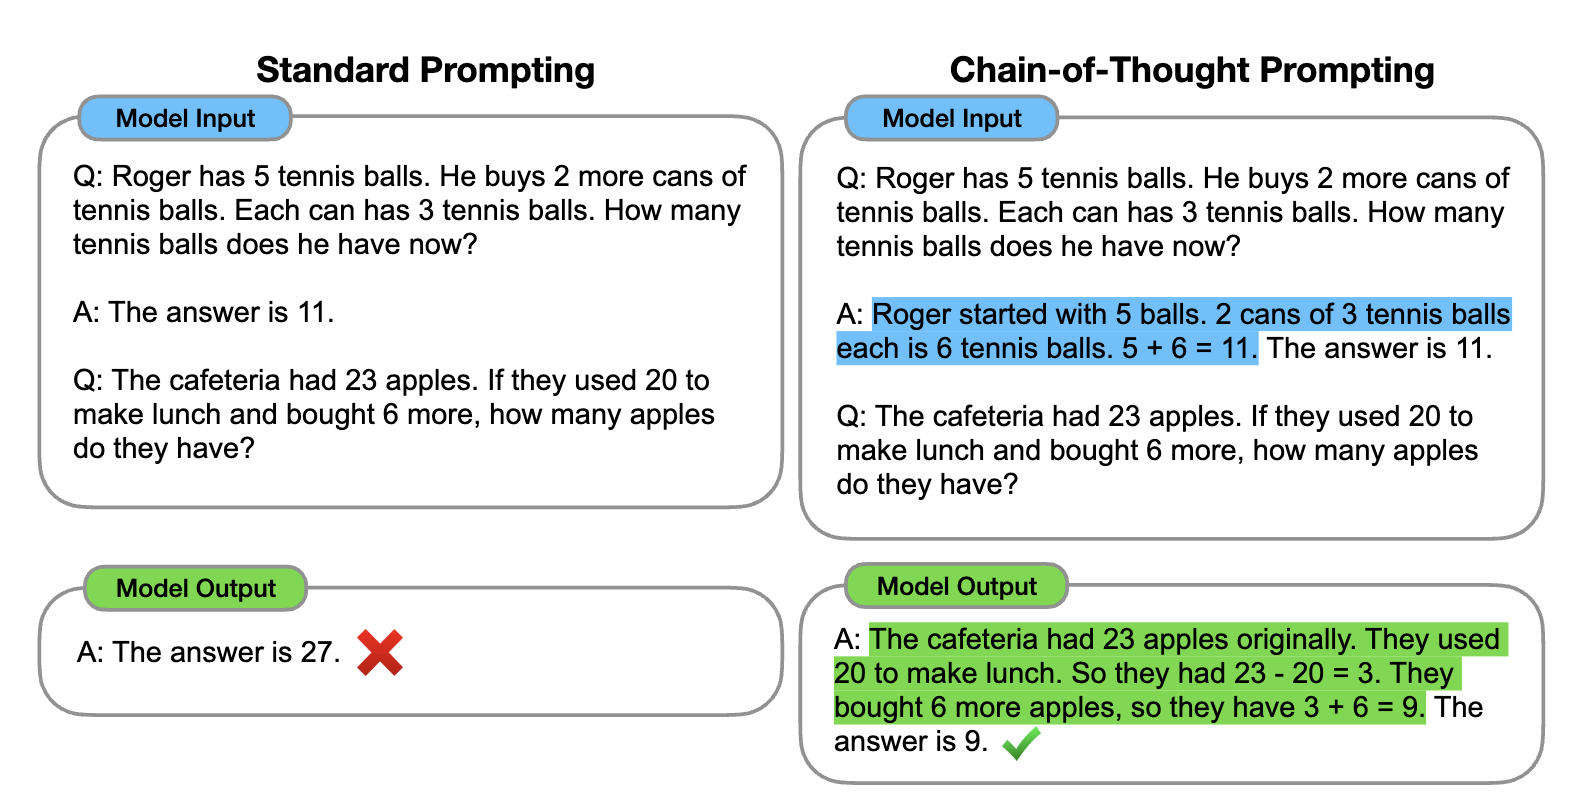

In [7]:
# we define a set of global variables that we will use throughout the lab

ANSWER_INSERT_STR = "The answer is "
QUESTION_STR = "Q: "
ANSWER_STR = "A: "
INSTRUCTIONS= "Solve the following math problem. Follow the example format.\n\n"

### Standard Prompting

Here, complete the function below to build a standard "one-shot" prompt: i.e a prompt with one example but not reasoning trace

In [22]:

## Exercise: Fill-in the dots
def build_standard_oneshot_prompt(dataset, index) :
  """Must return the prompt and the solution"""
  sample = dataset[index]
  question, answer = sample['question'], sample['answer']
  solution = "..."

  one_shot_example_q = "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"
  one_shot_example_a = "11"

  prompt = (INSTRUCTIONS + "..." + '\n' + \
         ANSWER_STR + ANSWER_INSERT_STR + "..." + "\n" + \
         QUESTION_STR + "..." + '\n' + \
          ANSWER_STR)
  answer = ANSWER_INSERT_STR + "..."
  return prompt, answer


In [9]:
prompt, solution = build_standard_oneshot_prompt(test_dataset, 10)
print(prompt)
print('\n-----\n')
print(solution)

Solve the following math problem. Follow the example format.

Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11
Q: A new program had 60 downloads in the first month. The number of downloads in the second month was three times as many as the downloads in the first month, but then reduced by 30% in the third month. How many downloads did the program have total over the three months?
A: 

-----

366


#### Generate with Ollama

In [194]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model=MODEL_NAME, messages=[
  {
    'role': 'user',
    'content': prompt
  },
], think=False, options={
    'seed' : 20,
    'temperature': 0.8, # Temperature sampling,
    'top_p' : 0.95, # Top P sampling
    'top_k' : 64, # Top K sampling
    'num_predict' : 500 # Maximum number of tokens to generate
    })

In [195]:
print(response['message']['content'])

A: The answer is 210



### 8-shots standard prompting

We will build an 8-shots prompt. The reason we dot this is that it is the standard evaluation strategy used on GSM8K.

We will first generate an 8-shot prompt with standard prompting, and then move-on to CoT

Exercise: complete the following functions and execute an LLM call to check the answer

#### Exercise

In [196]:
import numpy as np


def get_standard_shots(train_dataset, n_shots=8) :
  # Fixing numpy seed to get deterministic results
  np.random.seed(2026)

  # sample 8 random indices from the `train_dataset` using numpy
  shots_idx = "..."

  # Initialize the shots with the Instruction prompt
  few_shot_prompt = INSTRUCTIONS

  # iteratively build the examples
  for idx in shots_idx :
      "..."
      few_shot_prompt += QUESTION_STR + "..." + "\n" +\
                      ANSWER_STR  + ANSWER_INSERT_STR + "..." + "\n"
  return few_shot_prompt


def build_standard_few_shot_prompt(train_dataset, test_dataset, test_index, n_shots=8) :
  """Build standard few shots by sampling `n_shots` using the `get_standard_shots` function"""
  # getting the examples
  shots = get_standard_shots(train_dataset, n_shots=n_shots)

  # Get the right sample from test_dataset and get question + solution
  question = "..."
  solution = "..."

  prompt = shots + QUESTION_STR + question + "\n" + ANSWER_STR.strip()
  return prompt, solution

In [198]:
print(get_standard_shots(train_dataset, 8))

Solve the following math problem. Follow the example format.

Q: Charles is moving from Springfield, which has 482,653 people, to Greenville, which has 119,666 fewer people. What is the total population of Springfield and Greenville?
A: The answer is 845,640
Q: The student council sells scented erasers in the morning before school starts to help raise money for school dances. The local bookstore donated 48 boxes of erasers. There are 24 erasers in each box. If the student council sells the erasers for $0.75 each, how much money will they make?
A: The answer is 864
Q: Rodney and Todd are rowing down a river that is 50 yards wide at one end. If the river's width increases from this end uniformly by 2 yards every 10 meters along, and they row along the river at a rate of 5 m/s, how long (in seconds) will it take them to get to the point where the river is 80 yards wide?
A: The answer is 30
Q: On national lipstick day, half of the students who attended class wore colored lipstick.  Of thos

In [199]:
prompt, answer = build_standard_few_shot_prompt(train_dataset, test_dataset, 10, 8)
print(prompt)
print('=======')
print(answer)

Solve the following math problem. Follow the example format.

Q: Charles is moving from Springfield, which has 482,653 people, to Greenville, which has 119,666 fewer people. What is the total population of Springfield and Greenville?
A: The answer is 845,640
Q: The student council sells scented erasers in the morning before school starts to help raise money for school dances. The local bookstore donated 48 boxes of erasers. There are 24 erasers in each box. If the student council sells the erasers for $0.75 each, how much money will they make?
A: The answer is 864
Q: Rodney and Todd are rowing down a river that is 50 yards wide at one end. If the river's width increases from this end uniformly by 2 yards every 10 meters along, and they row along the river at a rate of 5 m/s, how long (in seconds) will it take them to get to the point where the river is 80 yards wide?
A: The answer is 30
Q: On national lipstick day, half of the students who attended class wore colored lipstick.  Of thos

#### Generate with Ollama

In [200]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model=MODEL_NAME, messages=[
  {
    'role': 'user',
    'content': prompt
  },
], think=False, options={
    'seed' : random.randint(0,10),
    'temperature': 0.8, # Temperature sampling,
    'top_p' : 0.95, # Top P sampling
    'top_k' : 64, # Top K sampling
    'num_predict' : 50 # Maximum number of tokens to generate
    })

In [201]:
print(response['message']['content'])

A: The answer is 210


### CoT 1-shot

Exercise: complete the following functions and execute an LLM call to check the answer

#### Exercise

In [202]:
## Exercise: Fill-in the dots
def build_cot_oneshot_prompt(dataset, index) :
      """Must return the prompt and the solution"""
      sample = dataset[index]
      question, answer = sample['question'], sample['answer']
      solution = "..."
    
      one_shot_example_q = "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"
      one_shot_example_r = "Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11."
      one_shot_example_a = "11"
    
      prompt = (INSTRUCTIONS + "..." + '\n' + \
             ANSWER_STR + "..." + ANSWER_INSERT_STR + "..." + "\n" + \
             QUESTION_STR + "..." + '\n' + \
              ANSWER_STR)
      answer = ANSWER_INSERT_STR + "..."
      return prompt, answer

In [9]:
prompt, solution = build_cot_oneshot_prompt(test_dataset, 10)
print(prompt)
print('\n-----\n')
print(solution)

Solve the following math problem. Follow the example format.

Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11
Q: A new program had 60 downloads in the first month. The number of downloads in the second month was three times as many as the downloads in the first month, but then reduced by 30% in the third month. How many downloads did the program have total over the three months?
A: 

-----

366


In [ ]:
# Don't forget to increase the `num_predict` parameter when using CoT, as the generation can be longer

response: ChatResponse = chat(model=MODEL_NAME, messages=[
  {
    'role': 'user',
    'content': prompt
  },
], think=False, options={
    #'seed' : random.randint(0,10),
    'temperature': 0.8, # Temperature sampling,
    'top_p' : 0.95, # Top P sampling
    'top_k' : 64, # Top K sampling
    'num_predict' : 200 # Maximum number of tokens to generate
    })

In [207]:
print(response['message']['content'])

A: In the first month, there were 60 downloads. In the second month, there were 3 * 60 = 180 downloads. In the third month, there were 180 * 0.30 = 54 fewer downloads, so 180 - 54 = 126 downloads. The total number of downloads over the three months is 60 + 180 + 126 = 366. The answer is 366.


### CoT 8-shots

Exercise: complete the following functions and execute an LLM call to check the answer

#### Exercise

In [9]:
import numpy as np


def get_cot_shots(train_dataset, n_shots=8) :
  # Fixing numpy seed to get deterministic results
  np.random.seed(2026)

  # sample 8 random indices from the `train_dataset` using numpy
  shots_idx = "..."

  # Initialize the shots with the Instruction prompt
  few_shot_prompt = INSTRUCTIONS

  # iteratively build the examples
  for idx in shots_idx :
      "..."
      few_shot_prompt += QUESTION_STR + "..." + "\n" +\
                      ANSWER_STR  + ANSWER_INSERT_STR + "..." + "\n"
  return few_shot_prompt


def build_cot_few_shot_prompt(train_dataset, test_dataset, test_index, n_shots=8) :
  """Build standard few shots by sampling `n_shots` using the `get_standard_shots` function"""
  # getting the examples
  shots = get_standard_shots(train_dataset, n_shots=n_shots)

  # Get the right sample from test_dataset and get question + solution
  question = "..."
  solution = "..."

  prompt = shots + QUESTION_STR + question + "\n" + ANSWER_STR.strip()
  return prompt, solution

In [11]:
prompt, solution = build_cot_few_shot_prompt(train_dataset, test_dataset, 10, n_shots=8)
print(prompt)
print('\n-----\n')
print(solution)

Solve the following math problem. Follow the example format.

Q: Charles is moving from Springfield, which has 482,653 people, to Greenville, which has 119,666 fewer people. What is the total population of Springfield and Greenville?
A: Greenville has 482,653 - 119,666 = 362,987 people.
So, the total population of Springfield and Greenville is 482,653 + 362,987 = 845,640. The answer is 845640
Q: The student council sells scented erasers in the morning before school starts to help raise money for school dances. The local bookstore donated 48 boxes of erasers. There are 24 erasers in each box. If the student council sells the erasers for $0.75 each, how much money will they make?
A: There are 48 boxes x 24 erasers = 1,152 erasers.
The student council will make 1,152 erasers x $0.75 = $864. The answer is 864
Q: Rodney and Todd are rowing down a river that is 50 yards wide at one end. If the river's width increases from this end uniformly by 2 yards every 10 meters along, and they row alon

In [215]:
# Don't forget to increase the `num_predict` parameter when using CoT, as the generation can be longer

response: ChatResponse = chat(model=MODEL_NAME, messages=[
  {
    'role': 'user',
    'content': prompt
  },
], think=False, options={
    #'seed' : random.randint(0,10),
    'temperature': 0.8, # Temperature sampling,
    'top_p' : 0.95, # Top P sampling
    'top_k' : 64, # Top K sampling
    'num_predict' : 200 # Maximum number of tokens to generate
    })

In [216]:
print(response['message']['content'])

The number of downloads in the second month was 60 * 3 = 180.
The number of downloads in the third month was 180 * (1 - 0.30) = 180 * 0.70 = 126.
The total number of downloads over the three months was 60 + 180 + 126 = 366. The answer is 366


## Self-Consistency

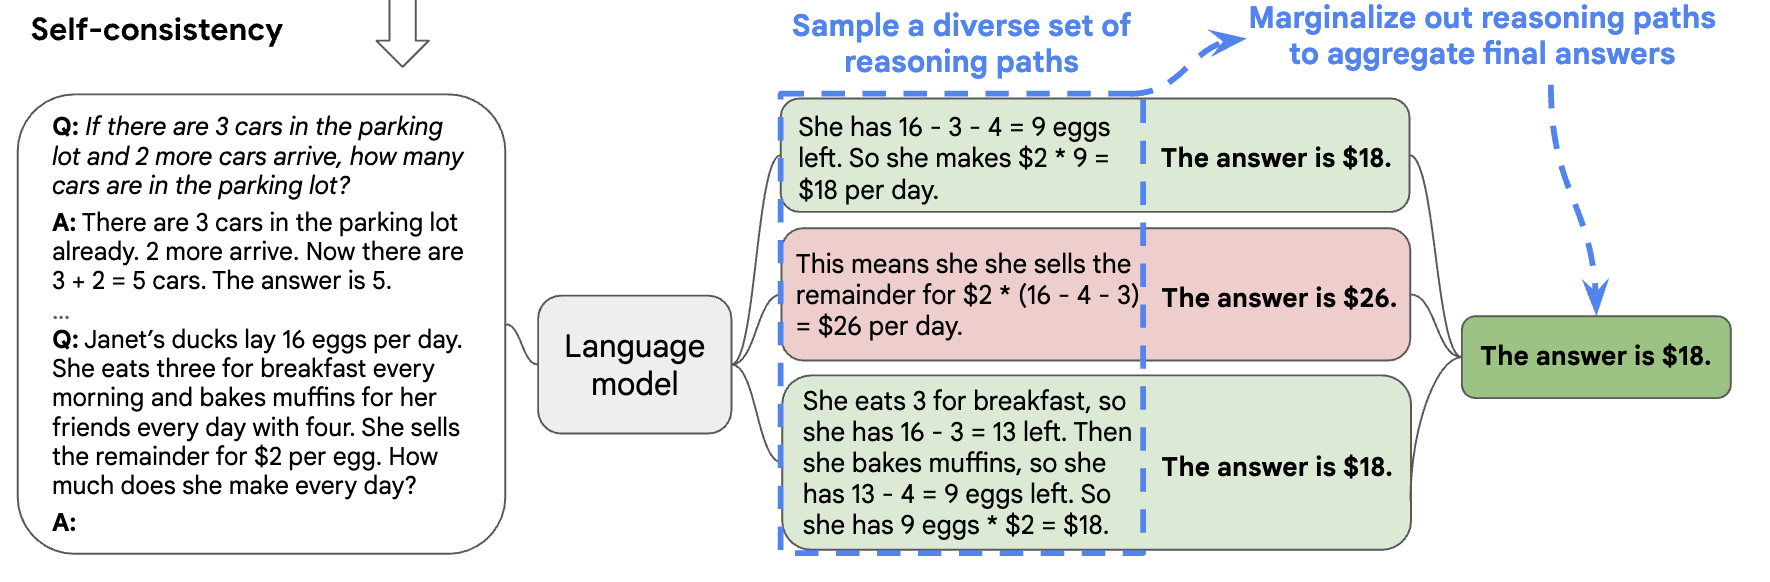

To run Self-Consistency, we will use the `build_cot_oneshot_prompt` we created above to first get a `CoT` prompt. You can also use more examples, at the cost of longer inference time.

Then, the resulting `CoT` prompt needs to be run multiple times, making sure that sampling is activated (tweak `temperature`, `top_k`, `top_p` and the `seed` parameters).

Finally, need to parse all generated answers and find the most popular one. The exercise below runs you through everything


#### Exercise

In [13]:
# Start by filling this function

INVALID_ANSWER = '[invalid]'

def extract_answer_from_model(text) : 
  match = re.search("...", text)
  # handle cases where the regex match returns nothing
  if match :
    return "..."
  else :
    return '...'

In [10]:
# Here, complete the self-consistency loop
from tqdm import tqdm

def self_consistency(dataset, index, num_loop=10) : 
    all_answers = []
    cot_prompt = build_cot_oneshot_prompt(dataset, index)
    
    for k in "..." : 
        
        response: ChatResponse = chat(model=MODEL_NAME, messages=[
          {
            'role': 'user',
            'content': cot_prompt
          },
        ], think=False, options={
            'seed' : k,
            'temperature': 0.8, # Temperature sampling,
            'top_p' : 0.95, # Top P sampling
            'top_k' : 64, # Top K sampling
            'num_predict' : 200 # Maximum number of tokens to generate
            })
        answer = "..."
        all_answers.append(answer)

    counts =  "..." 
    maj_vote, maj_count = "..."
    
    return maj_vote, counts, answer

In [53]:
maj_vote, counts, answer  = self_consistency(test_dataset, 10, 5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.40s/it]


In [54]:
maj_vote, counts, answer

('366', Counter({'366': 5}), '366')

## Evaluation on a small Test Subset

For evaluation, we will be using a larger model: Gemma3 4b. We will run 2 separate Ollama servers to access them concurrently and speed up inference 

In [ ]:
!ollama pull gemma3:4b

In [13]:
MODEL_NAME = "gemma3:4b"

We will also run individual instance of Ollama to run requests concurrently

In [355]:
# kills current ollama process
!pkill ollama

In [ ]:
# start 2 new ollama instances
!OLLAMA_HOST=127.0.0.1:11434 nohup ollama serve & 
!OLLAMA_HOST=127.0.0.1:11435 nohup ollama serve &

In [14]:
from ollama import Client
import json 
# from multiprocessing import Process
import multiprocessing as mp
from tqdm import tqdm
import numpy as np

### Standard Prompting & CoT prompting

Below we build the 100 prompts we will use for evaluation

In [15]:
NUM_TEST = 100
np.random.seed(42)
test_indices = np.arange(len(test_dataset))
np.random.shuffle(test_indices)
# prompts = [build_cot_few_shot_prompt(train_dataset, test_dataset, i, n_shots=2) for i in test_indices[:NUM_TEST]]
# prompts = [build_standard_oneshot_prompt(test_dataset, i) for i in test_indices[:NUM_TEST]]
prompts = [build_cot_oneshot_prompt(test_dataset, i) for i in test_indices[:NUM_TEST]]

messages = [[
          {
            'role': 'user',
            'content': p
          }
        ] for p,a in prompts]

gt_answers = [a for p,a in prompts]

Then we split them in 2 batches of 50 prompts each that will be sent to each Ollama individual run

In [16]:
# They also take the batch index as argument to ensure we send the data to right host
batch_size = 50
batches = []
for i, b in enumerate(range(0, NUM_TEST, batch_size)) : 
    # data = [(i,pr) for pr in messages[b:b+batch_size]]
    batches.append(messages[b:b+batch_size])

def run_batch(batched_messages, host, process_id):
    answers = [] 
    if process_id == 0 : 
        iterator = tqdm(batched_messages, desc=f"Batch {process_id}", total=len(batched_messages))
    else : 
        iterator = batched_messages
        
    for m in iterator : 
        answers.append( Client(host=host).chat(model=MODEL_NAME, messages=m, think=False, options={
                # 'seed' : 0,
                'temperature': 0.9, # Temperature sampling,
                'num_predict' : 500 # Maximum number of tokens to generate
                }))
    return answers

Example dual-inference with python `multiprocessing` package. 

In [46]:
import multiprocessing as mp

host_1 = '127.0.0.1:11434'
host_2 = '127.0.0.1:11435'

def run_batch_wrapper(args):
    return run_batch(*args)

jobs = [
    (batches[0], host_1, 0),
    (batches[1], host_2, 1),
]

with mp.Pool(processes=2) as pool:
    results = pool.map(run_batch_wrapper, jobs)

results_1, results_2 = results
results = results_1 + results_2

Batch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


### Exercise

Run the evaluation on these 100 examples for all type of prompts and see which one perform the best

### Answer

### Self-Consistency

To evaluate self-consistency, we will consider an integer `k` as the number of independent generations, and simply send $k*100$ requests to Ollama (actually we will send $k*\frac{100}{2}$ to each independent sever$

In [18]:
# Lets put 3 independent generations for now 
k = 3

messages = []
gt_answers = []

for i in test_indices[:NUM_TEST] : 
    # Populate the messages and gt_answers with the right prompts, as described above
    "..."


In [ ]:
# Build batches
batch_size = len(messages) // 2
batches = []
for i, b in enumerate(range(0, NUM_TEST*k, batch_size)) : 
    # data = [(i,pr) for pr in messages[b:b+batch_size]]
    batches.append(messages[b:b+batch_size])

In [19]:
# Run on both hosts
host_1 = '127.0.0.1:11434'
host_2 = '127.0.0.1:11435'

def run_batch_wrapper(args):
    return run_batch(*args)

jobs = [
    (batches[0], host_1, 0),
    (batches[1], host_2, 1),
]

with mp.Pool(processes=2) as p:
    results = p.map(run_batch_wrapper, jobs)

results_1, results_2 = results
results = results_1 + results_2

Batch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:49<00:00,  2.33s/it]


### Exericse

Run evaluation for Self-Consistency

### Answer

# Part 2: Tree-of-Thoughts

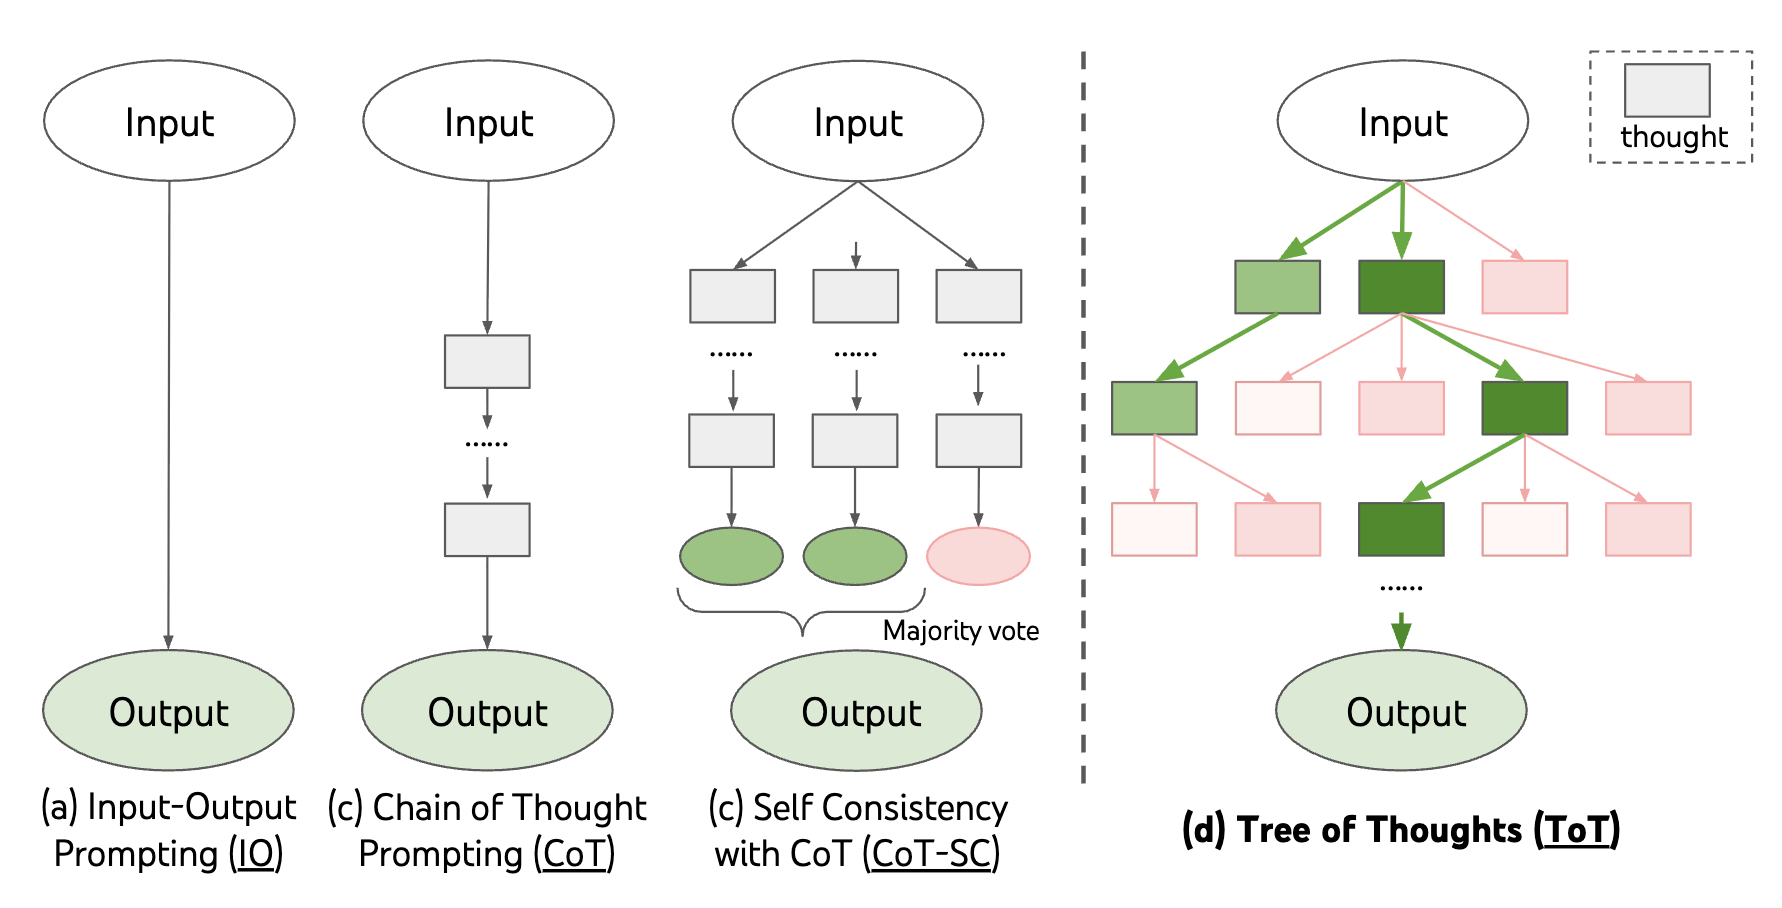

We focus here on the **Game of 24** described below

**Input**: Four integers (e.g., `[4, 5, 6, 10]`)

**Goal**: Combine them with `{+, −, ×, ÷}` to produce exactly `24`

**Constraint**: Each number used exactly once

**Output**: A sequence of three operations showing the path to `24`

**Example**:

```
Input: 4 5 6 10
10 - 4 = 6     (remaining: 5 6 6)
5 * 6 = 30     (remaining: 6 30)
30 - 6 = 24    (remaining: 24)
Answer: (5 * (10 - 4)) - 6 = 24
```

From the lecture, we know that each node in the tree will be constructed via `2` LLM calls:

- A *propose prompt* that will propose a new solution
- A *value prompt* that will judge if the current solution is good enough

Each of these prompts are CoT prompts, and we provide the prompts used in the original paper below

### Important

This part on ToT is intended more as a playground than a real exercise. I did not manage to make it work properly with Gemma3-1b, so you are encouraged to test various models (list available [here](https://ollama.com/search)). Perhaps larger models for example, or even "reasoning models" such as Qwen3 series.

I noticed when testing that smaller models such as Gemma3-1b often do not follow exactly the examples provided in the `propose` and `value` prompt. You are encouraged to try the following:

#### Things to play with 

- Modify the `instruct_prompt` in the `Game23ToT` class below to force the model at following the desired format etc..
- Modify the `value` and/or `propose` prompts located in `prompts/value_prompt.txt` and `prompts/propose_prompt.txt`. You can modify them directly and reload them via the cell below.
- Try different sampling parameters (`top_p`, `top_k`, `temperature`)
- Add heuristics to the `Game24ToT` class to help it solve the problem:
   - Remove duplicate candidates: unreliable LLMs will sometime produce duplicates in their answer. We can prune the duplicates before evaluating.
   - Remove impossible candidates: unreliable LLMs can produce candidates with negative values and/or float values. Those does not help find the answer, so we can prune them before evaluating.
   - Evaluating only candidates that make sense for the current step: unreliable LLMs can produce unwanted candidates (e.g. 1st step should produce 3 numbers `(left: X Y Z)` but sometimes the LLM returns `(left: X Y)`. We can prune these candidates as well.

### Setup

In [142]:
PROPOSE_PROMPT = open('prompts/propose_prompt.txt').read()
VALUE_PROMPT = open('prompts/value_prompt.txt').read()
VALUE_LAST_STEP_PROMPT = open('prompts/value_last_step_prompt.txt').read()
COT_PROMPT = open('prompts/cot_prompt.txt').read()

There's also a *value prompt specific for the last step* as the goal of last step is to evaluate whether the last node reaches 24 or not.

Finally the last prompt used is another CoT prompt that will just be used to convert the final ToT answer to the desired format

In [ ]:
# pulling a new model to make it available by Ollama
!ollama pull qwen3:8b

## The Game24 Class

The following class implements the task of Game24. It mostly takes care of prompting operation

In [51]:
class Game24Task():
    """
    Input (x)   : a string of 4 numbers
    Output (y)  : a trajectory of 3 steps to reach 24
    Reward (r)  : 0 or 1, depending on whether the trajectory is correct
    Input Example: 
        1 2 3 4
    Output Example: 
        1 + 2 = 3 (left: 3 3 4)
        3 + 3 = 6 (left: 4 6)
        6 * 4 = 24 (left: 24)
        (1 + 2 + 3) * 4 = 24
    """

    def __init__(self):
        self.steps = 4
        self.value_cache = {}
        
    def get_current_numbers(self, y: str) -> str:
        """This function just extracts which numbers are left given
        the last state of the current solution 
        
        args:
        y: str, the state of the current solution, ordered by steps."""
        last_line = y.strip().split('\n')[-1]
        return last_line.split('left: ')[-1].split(')')[0]
        
    def propose_prompt_wrap(self, x: str, y: str='') -> str:
        """Returns the `propose_prompt` for the current number lefts in `y`"""
        current_numbers = self.get_current_numbers(y if y else x)
        if current_numbers == '24':
            prompt = COT_PROMPT.format(input=x) + 'Steps:' + y
        else:
            prompt = PROPOSE_PROMPT.format(input=current_numbers)
        return prompt
    
    def value_prompt_wrap(self, x: str, y: str) -> str:
        """Returns the `value_prompt` for the current solution `y`"""
        last_line = y.strip().split('\n')[-1]
        if 'left: ' not in last_line:  # last step
            ans = last_line.lower().replace('answer: ', '')
            return VALUE_LAST_STEP_PROMPT.format(input=x, answer=ans)
        current_numbers = self.get_current_numbers(y)
        return VALUE_PROMPT.format(input=current_numbers)
    
    def value_outputs_unwrap(self, x: str, y: str, value_outputs: list) -> float:
        if len(y.strip().split('\n')) == 4 and 'answer' not in y.lower():
            return 0
        value_names = [_.split('\n')[-1] for _ in value_outputs]
        value_map = {'impossible': 0.001, 'likely': 1, 'sure': 20}
        value = sum(value * value_names.count(name) for name, value in value_map.items())
        return value



Now we build the main solver class. It will loop during 4 steps (the 4 steps required by Game24) and propose + evaluate each node in the Tree.

In [304]:
from ollama import chat
from ollama import ChatResponse
import itertools

class Game24ToT() : 
    def __init__(
        self,
        model_name='gemma3:1b',
        n_evaluate_sample=3,
        n_select_sample=5
    ) : 

        self.model_name = model_name
        self.n_evaluate_sample= n_evaluate_sample
        self.n_select_sample = n_select_sample
        self.task = Game24Task()
        self.instruct_prompt = "**Understand the task with the examples below. Follow the provided format and do not repeat arithmetic operations.**"
    
    def llm_call(self, prompt, n, add_instruction = False) : 
        """
        prompt: str, the prompt to sent to the model
        n: int, number of independent call to the LLM with the same prompt
        add_instruction: bool, if True, add the instruction prompt to the original prompt
        """
        outputs = []
        if add_instruction : 
            prompt = self.instruct_prompt + '\n\n' + prompt
        messages = [
            # {"role": "system", "content": self.instruct_prompt },
            {"role": "user", "content": prompt}]
        while n > 0 : 
            response = chat(model=self.model_name, messages=messages, think=False, options={
            # 'seed' : 20,
            'temperature': 0.7, # Temperature sampling,
            'top_p' : 0.95, # Top P sampling
            # 'top_k' : 64, # Top K sampling
            'num_predict' : 1000 # Maximum number of tokens to generate
            })
            outputs.append(response['message']['content'])
            n -= 1
        return outputs

    def get_proposals(self, x, y, add_instruction=False):
        """Runs a proposal given the current state"""
        propose_prompt = self.task.propose_prompt_wrap(x, y)
        proposals = self.llm_call(propose_prompt, n=1, add_instruction=add_instruction)[0].split('\n')
        return [y + _ + '\n' for _ in proposals]
    
    def get_values(self, x, ys, cache_value=True, add_instruction=False):
        """Evaluate all states (x,y_i) `n_evaluate_sample` times"""
        values = []
        local_value_cache = {}
        for y in tqdm(ys, desc = f"Step {self.global_step+1}/{self.task.steps}"):  # each partial output
            if y in local_value_cache:  # avoid duplicate candidates
                value = 0
            else:    
                value = self.get_value( x, y, cache_value=cache_value)
                local_value_cache[y] = value
            values.append(value)
        return values
        
    def get_value(self, x, y, cache_value=True):
        """Evaluate the given state (x,y) `n_evaluate_sample` times"""
        value_prompt = self.task.value_prompt_wrap(x, y)
        if cache_value and value_prompt in task.value_cache:
            return self.task.value_cache[value_prompt]
        value_outputs = self.llm_call(value_prompt, n=self.n_evaluate_sample, add_instruction=add_instruction)
        value = self.task.value_outputs_unwrap(x, y, value_outputs)
        if cache_value:
            self.task.value_cache[value_prompt] = value
        return value

    def solve(self, input_problem, to_print=True, add_instruction=False):
        """
        Construct the ToT and runs Breadth-First-Search (BFS).
        """
        x = input_problem
        ys = ['']  # current output candidates
        infos = []
        for step in range(self.task.steps):
            self.global_step = step
            print(f'Running Step {step+1}')
            
            # generation
            print(f'\t\tGenerating propositions')
            new_ys = [self.get_proposals(x, y, add_instruction=add_instruction) for y in ys]
            new_ys = list(itertools.chain(*new_ys))
            ids = list(range(len(new_ys)))
            print(f'\t\tProposal done')
            # evaluation
            print(f'\t\tEvaluating {len(new_ys)} propositions')
            values = self.get_values(x, new_ys, add_instruction=add_instruction)
            # print(values)
            print(f'\t\tDone Evaluating')

            print(f'Selecting only Top {self.n_select_sample} propositions')
            # selection
            select_ids = sorted(ids, key=lambda x: values[x], reverse=True)[:self.n_select_sample]
            select_new_ys = [new_ys[select_id] for select_id in select_ids]
            # print(select_new_ys)
            
            # log
            if to_print: 
                sorted_new_ys, sorted_values = zip(*sorted(zip(new_ys, values), key=lambda x: x[1], reverse=True))
                print(f'-- new_ys --: {sorted_new_ys}\n-- sol values --: {sorted_values}\n-- choices --: {select_new_ys}\n')
            
            infos.append({'step': step, 'x': x, 'ys': ys, 'new_ys': new_ys, 'values': values, 'select_new_ys': select_new_ys})
            ys = select_new_ys
        
        if to_print: 
            print(ys)
        return ys, {'steps': infos}

In [305]:
tot_solver= Game24ToT(model_name="qwen3:8b", n_evaluate_sample=2 , n_select_sample=5)

In [306]:
print(tot_solver.llm_call(tot_solver.task.propose_prompt_wrap('1 1 11 11', ''), 1)[0])

Possible next steps:  
1 + 1 = 2 (left: 2 11 11)  
11 - 1 = 10 (left: 1 10 11)  
11 / 1 = 11 (left: 1 11 11)  
11 - 1 = 10 (left: 1 10 11)  
11 + 1 = 12 (left: 1 11 12)  
11 * 1 = 11 (left: 1 11 11)  
11 / 1 = 11 (left: 1 11 11)  
1 + 11 = 12 (left: 11 12)  
11 - 1 = 10 (left: 1 10 11)  
11 + 1 = 12 (left: 1 11 12)


In [307]:
tot_solver.solve('1 1 11 11')

Running Step 1
		Generating propositions
		Proposal done
		Evaluating 11 propositions


Step 1/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


		Done Evaluating
Selecting only Top 10 propositions
-- new_ys --: ('11 + 1 = 12 (left: 1 11 12)  \n', '11 - 1 = 10 (left: 1 10 11)  \n', '11 / 1 = 11 (left: 1 11 11)  \n', '11 * 1 = 11 (left: 1 11 11)  \n', '1 + 1 = 2 (left: 2 11 11)  \n', '1 + 11 = 12 (left: 11 12)  \n', '1 + 11 = 12 (left: 11 12)\n', 'Possible next steps:  \n', '11 - 1 = 10 (left: 1 10 11)  \n', '11 / 1 = 11 (left: 1 11 11)  \n', '11 - 1 = 10 (left: 1 10 11)  \n')
-- sol values --: (20.0, 1.0, 1.0, 1.0, 0.001, 0.001, 0.001, 0.0, 0, 0, 0)
-- choices --: ['11 + 1 = 12 (left: 1 11 12)  \n', '11 - 1 = 10 (left: 1 10 11)  \n', '11 / 1 = 11 (left: 1 11 11)  \n', '11 * 1 = 11 (left: 1 11 11)  \n', '1 + 1 = 2 (left: 2 11 11)  \n', '1 + 11 = 12 (left: 11 12)  \n', '1 + 11 = 12 (left: 11 12)\n', 'Possible next steps:  \n', '11 - 1 = 10 (left: 1 10 11)  \n', '11 / 1 = 11 (left: 1 11 11)  \n']

Running Step 2
		Generating propositions
		Proposal done
		Evaluating 80 propositions


Step 2/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.22it/s]


		Done Evaluating
Selecting only Top 10 propositions
-- new_ys --: ('11 - 1 = 10 (left: 1 10 11)  \nPossible next steps:  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 + 1 = 12 (left: 12 12)  \n', '11 + 1 = 12 (left: 1 11 12)  \n12 - 1 = 11 (left: 11 11)  \n', '11 + 1 = 12 (left: 1 11 12)  \n12 - 11 = 1 (left: 1 1)  \n', '11 + 1 = 12 (left: 1 11 12)  \n12 / 1 = 12 (left: 11 12)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 - 1 = 10 (left: 10 12)  \n', '11 + 1 = 12 (left: 1 11 12)  \n12 / 11 = 1.09 (left: 1 1.09)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 / 1 = 11 (left: 11 12)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 - 1 = 10 (left: 10 12)\n', '11 - 1 = 10 (left: 1 10 11)  \n1 + 10 = 11 (left: 11 11)  \n', '11 - 1 = 10 (left: 1 10 11)  \n10 + 1 = 11 (left: 11 11)  \n', '11 - 1 = 10 (left: 1 10 11)  \n11 - 1 = 10 (left: 10 10)  \n', '11 - 1 = 10 (left: 1 10 11)  \n11 - 10 = 1 (left: 1 1)  \n', '11 - 1 = 10 (left: 1 10 11)  \n10 - 1 = 9 

Step 3/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.33it/s]


		Done Evaluating
Selecting only Top 10 propositions
-- new_ys --: ('11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 + 12 = 24 (left: 24)  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n', '11 + 1 = 12 (left: 1 11 12)  \n11 + 1 = 12 (left: 12 12)  \n12 + 12 = 24 (left: 24)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 + 1 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 + 1 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n', '11 + 1 = 12 (left: 1 11 12)  \n11 + 1 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n', '11 + 1 = 12 (left: 1 11 12)  \n12 - 1 = 11 (left: 11 11)  \n11 + 11 = 22 (left: 22)  \n', '11 + 1 = 12 (left: 1 11 12)  \n12 - 1 = 11 (left: 11 11)  \n11 * 11 = 121 (left: 121)  \n', '11 + 1 = 12 (left: 1 11 12)

Step 4/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:27<00:00,  1.23s/it]

		Done Evaluating
Selecting only Top 10 propositions
-- new_ys --: ('11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 + 12 = 24 (left: 24)  \nAnswer: (11 + 1) + (1 + 11) = 24\n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \nPossible next steps:  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \n(No possible next steps, as there is only one number left.)\n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n**Input: 1**  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n**Possible next steps:** (No possible next steps, as there is only one number left.)\n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n**Input: 0**  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n**Possible next steps:**  \n', '11 + 1 = 12 (left: 1 11 12)  \n1 + 11

(['11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 + 12 = 24 (left: 24)  \nAnswer: (11 + 1) + (1 + 11) = 24\n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \nPossible next steps:  \n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 * 12 = 144 (left: 144)  \n(No possible next steps, as there is only one number left.)\n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n**Input: 1**  \n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 / 12 = 1 (left: 1)  \n**Possible next steps:** (No possible next steps, as there is only one number left.)\n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n**Input: 0**  \n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\n**Possible next steps:**  \n',
  '11 + 1 = 12 (left: 1 11 12)  \n1 + 11 = 12 (left: 12 12)  \n12 - 12 = 0 (left: 0)\nNo pos